In [1]:
# !conda install -c conda-forge librosa

# !conda install tqdm

In [2]:
import torch as ch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as Data

import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import os
import string
import librosa
import tqdm
import shutil
# !pip install lws
import lws
import IPython.display as ipd
from importlib import reload

import hyperparams
from hyperparams import Hyperparams as params
reload(hyperparams)
import datasets
reload(datasets)
import dcttsModel
from dcttsModel import C,Cs,Css,D,HC,TextEnc,AudioEnc,AudioDec,Text2Mel,SSRN
# reload(dcttsModel)

In [3]:
# conv = C(3,2,3,1,0)
# tconv = D(3,2,2,1,2)
# hconv = HC(2,2,3,1,0)
# I.shape,conv(I).shape,tconv(I).shape,hconv(I).shape

In [4]:
# # textEnc = TextEnc(d=d,e=e,c2i=c2i)
# # audioEnc = AudioEnc(d=d,F=F)
# audioDec = AudioDec(d=params.d,F=params.F).to(dev)

# ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
# text2Mel = Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)

# # alpha = 0.5, super-separable
# [sum(np.prod(p.size()) for p in m.parameters()) for m in (text2Mel,audioDec,ssrn)]

In [5]:
dev = ch.device('cuda:0' if ch.cuda.is_available() else 'cpu')
if ch.cuda.is_available():
    ch.multiprocessing.set_start_method("spawn",force=True)

In [6]:
class DbinLoss(ch.nn.Module):
    def __init__(self):
        super(DbinLoss,self).__init__()
    
    def forward(self,Yhat,Y):
        EPS = 1e-12
        elLoss = -(Y*ch.log(Yhat+EPS)+(1-Y)*ch.log(1-Yhat+EPS))
#         return elLoss.view(elLoss.shape[0],-1).mean(1)
        return elLoss.mean()

class GAttLoss(ch.nn.Module):
    def __init__(self):
        super(GAttLoss,self).__init__()
            
    def forward(self,A):
        _,N,T = A.shape
        W = ch.Tensor([[np.e**(-(n/N-t/T)**2 / (2*params.g**2)) 
                        for t in range(1,T+1)] 
                       for n in range(1,N+1)])
        W = W.to(dev)
        return ((1-W)*A).mean()

In [7]:
L1Fun = ch.nn.L1Loss()
BCEFun = ch.nn.BCELoss()
def MelFun(Shat,S): return L1Fun(Shat,S) + BCEFun(Shat,S)
DbinFun = DbinLoss()
GAttFun = GAttLoss()

In [8]:
def saveChkpt(state,model,root='.'):
#     chkptDir = os.path.join(root,'CHKPT'+''.join(p+str(v) for p,v in state['archparams']))
    chkptDir = root
    chkptPath = os.path.join(chkptDir,model+'Chkpt.pth.tar')
    bestPath = os.path.join(chkptDir,model+'Best.pth.tar')
    if not os.path.exists(chkptDir): os.makedirs(chkptDir)    
    ch.save(state,chkptPath)
    if state['lossHist'][-1] <= state['bestLoss']:
        shutil.copyfile(chkptPath,bestPath)
    print("SAVED EPOCH {}, LOSS {}, BEST LOSS {}".format(state['epoch'],state['lossHist'][-1],state['bestLoss']))

def loadChkpt(network,optimizer,model,dev,best,root='.'):
    # return epoch num and best loss of checkpoint
    chkptDir = root
    chkptPath = os.path.join(chkptDir,model+'Chkpt.pth.tar')
    bestPath = os.path.join(chkptDir,model+'Best.pth.tar')
    if not os.path.exists(chkptPath): return 0,[],float('inf')
    if best:
        state = ch.load(bestPath,map_location=dev)
    else:
        state = ch.load(chkptPath,map_location=dev)
    network.load_state_dict(state['modelState'])
    optimizer.load_state_dict(state['optimizerState'])
    if len(state['lossHist']) > 10: plt.plot(state['lossHist'])
    print("LOADED EPOCH {}, LOSS {}, BEST LOSS {}".format(state['epoch'],state['lossHist'][-1],state['bestLoss']))
    return state['epoch'],state['lossHist'],state['bestLoss']

LOADED EPOCH 181, LOSS 0.026464624747411528, BEST LOSS 0.026464624747411528


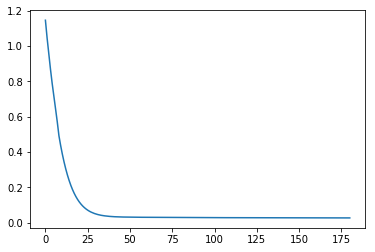

In [9]:
import datasets
from importlib import reload
reload(datasets)

nWorkers = 8 if ch.cuda.is_available() else 0
text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1),
                                 batch_size=16,
                                 shuffle=True,
                                 num_workers=nWorkers)

text2Mel = Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)

text2MelOpt = ch.optim.Adam(text2Mel.parameters(),
                          lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 1
if load == 2:
    startEpoch,lossHist,bestLoss = loadChkpt(text2Mel,text2MelOpt,'text2Mel',dev,best=1)
if load == 1:
    startEpoch,lossHist,bestLoss = loadChkpt(text2Mel,text2MelOpt,'text2Mel',dev,best=0)
else:
    # COLD START - RESET text2Mel
    audioDec = AudioDec(d=params.d,F=params.F).to(dev)
    text2Mel = Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)
    text2MelOpt = ch.optim.Adam(text2Mel.parameters(),
                      lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

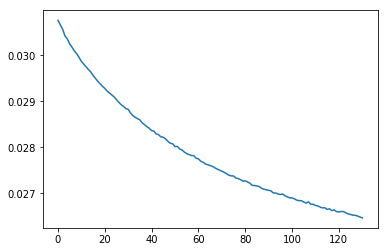

In [11]:
plt.plot(lossHist[50:])

EPOCH 181



epoch 181 total 0.026465825455735868 mel 0.02914745919406414 att 0.00020413238962646574
EPOCH 182



epoch 182 total 0.026460538415321665 mel 0.03544789180159569 att 0.00020628789206966758
EPOCH 183



epoch 183 total 0.02643721926846166 mel 0.023990627378225327 att 0.0002048960013780743
EPOCH 184



epoch 184 total 0.026434764872068788 mel 0.028605196624994278 att 0.00020391002180986106
EPOCH 185



epoch 185 total 0.026415261134171662 mel 0.022792881354689598 att 0.00021009534248150885
EPOCH 186



epoch 186 total 0.02640510148910889 mel 0.031157150864601135 att 0.0002133166854036972
EPOCH 187



epoch 187 total 0.02637287959623248 mel 0.018217304721474648 att 0.00020392067381180823
EPOCH 188



epoch 188 total 0.026380219505126798 mel 0.02546236850321293 att 0.00020519914687611163
EPOCH 189



epoch 189 total 0.02638280264088022 mel 0.034637995064258575 att 0.00020446654525585473
EPOCH 190



epoch 190 total 0.02635335801864293 mel 0.016521381214261055 att 0.00021039122657384723
EPOCH 191



epoch 191 total 0.026359485167620787 mel 0.025698183104395866 att 0.00020574522204697132
EPOCH 192



epoch 192 total 0.026329300433063686 mel 0.016695793718099594 att 0.00020459321967791766
EPOCH 193



epoch 193 total 0.02635055477939435 mel 0.03333892300724983 att 0.00021163452765904367
EPOCH 194



epoch 194 total 0.0263067261718992 mel 0.017967548221349716 att 0.00020807076361961663
EPOCH 195



epoch 195 total 0.026299106221256863 mel 0.024913059547543526 att 0.0002060145343421027
EPOCH 196



epoch 196 total 0.026321861017217386 mel 0.04113352671265602 att 0.00021467065380420536
EPOCH 197



epoch 197 total 0.026287373794770953 mel 0.026563378050923347 att 0.0002082873834297061
EPOCH 198



epoch 198 total 0.02628434292360473 mel 0.02323891595005989 att 0.0002094360679620877
EPOCH 199



epoch 199 total 0.026269603768057787 mel 0.024808604270219803 att 0.00020925769058521837
EPOCH 200



epoch 200 total 0.02626651193001377 mel 0.03497161343693733 att 0.0002117615076713264
SAVED EPOCH 201, LOSS 0.02626651193001377, BEST LOSS 0.02626651193001377


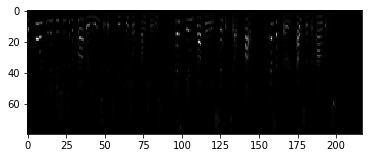

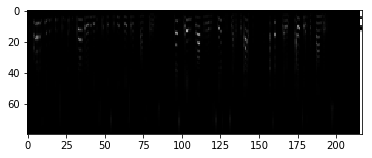

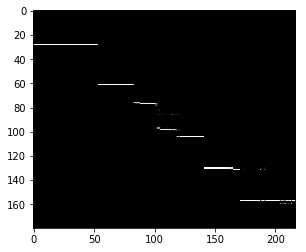

EPOCH 201



epoch 201 total 0.02625398913314983 mel 0.02853030525147915 att 0.00020600578864105046
EPOCH 202



epoch 202 total 0.026244484736069815 mel 0.030284792184829712 att 0.00020827726984862238
EPOCH 203



epoch 203 total 0.026248945512655955 mel 0.03977359086275101 att 0.00021622150961775333
EPOCH 204



epoch 204 total 0.026218128118163615 mel 0.021068613976240158 att 0.00021604669746011496
EPOCH 205



epoch 205 total 0.02621513285688055 mel 0.0237870030105114 att 0.00020593017688952386
EPOCH 206



epoch 206 total 0.026192527226825704 mel 0.014165179803967476 att 0.0002250118850497529
EPOCH 207



epoch 207 total 0.026195328185028996 mel 0.026350881904363632 att 0.0002086756139760837
EPOCH 208



epoch 208 total 0.026191484141372033 mel 0.028655871748924255 att 0.00020641939772758633
EPOCH 209



epoch 209 total 0.026198864983978557 mel 0.03853254020214081 att 0.00020178817794658244
EPOCH 210


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/aduriseti/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-3fb76d2df59f>", line 13, in <module>
    attloss = GAttFun(A)
  File "/home/aduriseti/anaconda3/lib/python3.6/site-packages/torch/nn/modules/module.py", line 477, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-6-40aa5bd2342a>", line 19, in forward
    for n in range(1,N+1)])
  File "<ipython-input-6-40aa5bd2342a>", line 19, in <listcomp>
    for n in range(1,N+1)])
  File "<ipython-input-6-40aa5bd2342a>", line 18, in <listcomp>
    for t in range(1,T+1)]
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aduriseti/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1863, in showtraceback
    stb = value._render_tr

KeyboardInterrupt: 

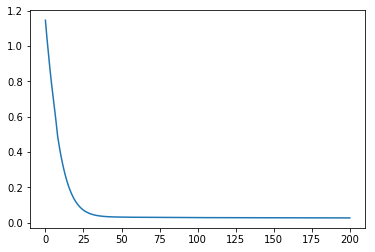

In [12]:
startEpoch = len(lossHist)
train = 1
for epoch in range(startEpoch,startEpoch+121*train):
    print("EPOCH",epoch)
    epochLoss = []
    for step,(batchL,batchS,_) in tqdm.tqdm_notebook(enumerate(text2MelLoader)):
        batchL = batchL.to(dev)
        batchS = batchS.to(dev)
        bL = ch.autograd.Variable(batchL)
        bS = ch.autograd.Variable(batchS)
        Shat,A = text2Mel(bL,bS)
        melloss = MelFun(Shat[:,:,:-1],bS[:,:,1:])
        attloss = GAttFun(A)
        loss = melloss + attloss
        epochLoss.append(loss.data.item())
        text2MelOpt.zero_grad()
        loss.backward()
        text2MelOpt.step()
#         if step > 10: break
    lossHist.append(np.mean(epochLoss))
    print('epoch',epoch,'total',lossHist[-1],
      'mel',melloss.data.item(),'att',attloss.data.item())
    if epoch % 5 == 0:
        bestLoss = min(lossHist[-1],bestLoss)
        state = {
            'epoch': epoch + 1,
            'archparams': {'sep': params.sep, 'alpha': params.alpha},
            'modelState': text2Mel.state_dict(),
            'lossHist': lossHist,
            'bestLoss': bestLoss,
            'optimizerState': text2MelOpt.state_dict() 
        }
        saveChkpt(state,model='text2Mel')
        plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(Shat[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(A[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        if len(lossHist) > 10: plt.plot(lossHist)

In [17]:
import datasets
reload(datasets)

nWorkers = 8 if ch.cuda.is_available() else 0
ssrnLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=0),
                             batch_size=16,
                             shuffle=True,
                             num_workers=nWorkers)

ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)

ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 0
if load == 2:
    startEpoch,lossHist,bestLoss = loadChkpt(ssrn,ssrnOpt,'ssrn',dev,best=1)
elif load == 1:
    startEpoch,lossHist,bestLoss = loadChkpt(ssrn,ssrnOpt,'ssrn',dev,best=0)
else:
    # COLD START - RESET SSRN
    ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
    ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

EPOCH 51


epoch 51 total 0.27168970180591984
EPOCH 52


epoch 52 total 0.2684762546753286
EPOCH 53


epoch 53 total 0.2653806180515594
EPOCH 54


epoch 54 total 0.26239783340991757
EPOCH 55


epoch 55 total 0.25952115143293825
SAVED EPOCH 56, LOSS 0.10130364269907795, BEST LOSS 0.10130364269907795


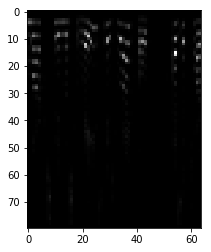

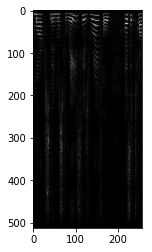

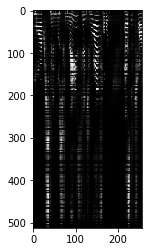

EPOCH 56


epoch 56 total 0.2567449657645922
EPOCH 57


epoch 57 total 0.2540635091287615
EPOCH 58


epoch 58 total 0.25147367996575254
EPOCH 59


epoch 59 total 0.24896831493750585
EPOCH 60


epoch 60 total 0.24654348995094488
SAVED EPOCH 61, LOSS 0.10105399075728744, BEST LOSS 0.10105399075728744


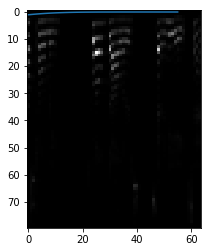

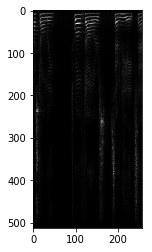

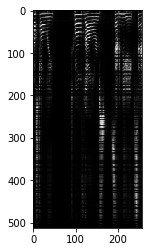

EPOCH 61


epoch 61 total 0.2441932930903878
EPOCH 62


epoch 62 total 0.24191811021856013
EPOCH 63


epoch 63 total 0.2397141705347058
EPOCH 64


epoch 64 total 0.2375779570572412
EPOCH 65


epoch 65 total 0.23550552075020278
SAVED EPOCH 66, LOSS 0.10079716079270662, BEST LOSS 0.10079716079270662


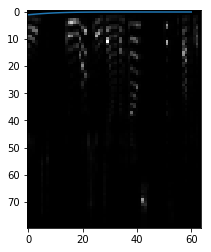

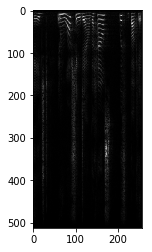

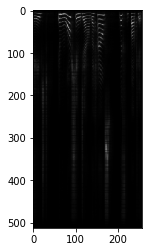

EPOCH 66


epoch 66 total 0.2334944313926895
EPOCH 67


epoch 67 total 0.23154217863277163
EPOCH 68


epoch 68 total 0.2296476634285769
EPOCH 69


epoch 69 total 0.22780782210404307
EPOCH 70


epoch 70 total 0.22602006458489995
SAVED EPOCH 71, LOSS 0.10087703824488085, BEST LOSS 0.10074124371827538


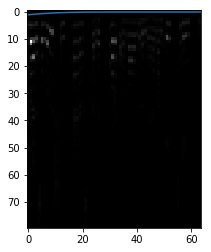

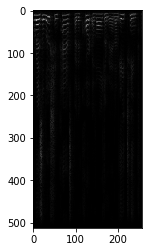

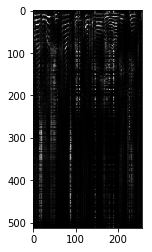

EPOCH 71


epoch 71 total 0.2242804813804182
EPOCH 72


epoch 72 total 0.22258838259309766
EPOCH 73


epoch 73 total 0.22094283727489444
EPOCH 74


epoch 74 total 0.21933980293875904
EPOCH 75


epoch 75 total 0.21777815328046204
SAVED EPOCH 76, LOSS 0.10065442890818439, BEST LOSS 0.10065442890818439


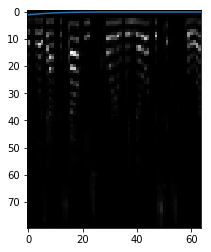

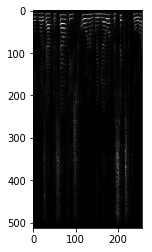

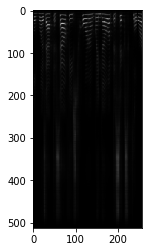

EPOCH 76


epoch 76 total 0.216256705115391
EPOCH 77


epoch 77 total 0.21477298516533502
EPOCH 78


epoch 78 total 0.21332877689623084
EPOCH 79


epoch 79 total 0.21191856913115661
EPOCH 80


epoch 80 total 0.2105436594418526
SAVED EPOCH 81, LOSS 0.1005508842975346, BEST LOSS 0.10051215569029993


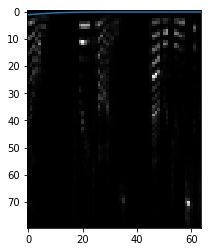

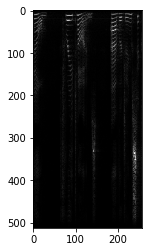

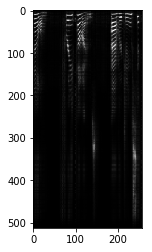

EPOCH 81


epoch 81 total 0.2092016439357366
EPOCH 82


epoch 82 total 0.20789158459812412
EPOCH 83


epoch 83 total 0.20661333480303112
EPOCH 84


epoch 84 total 0.20536406104231317
EPOCH 85


epoch 85 total 0.20414439420313085
SAVED EPOCH 86, LOSS 0.10047271287263329, BEST LOSS 0.10042506514200523


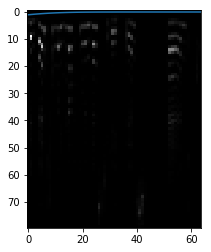

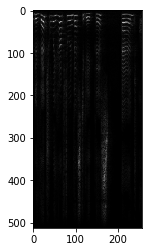

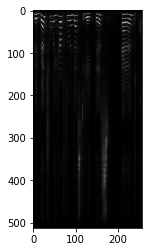

EPOCH 86


epoch 86 total 0.20295203357888933
EPOCH 87


epoch 87 total 0.2017875831075053
EPOCH 88


epoch 88 total 0.20064699835881636
EPOCH 89


epoch 89 total 0.19953317329003342
EPOCH 90


epoch 90 total 0.198442367279292
SAVED EPOCH 91, LOSS 0.10026982631256331, BEST LOSS 0.10026982631256331


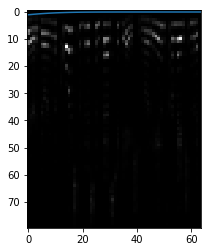

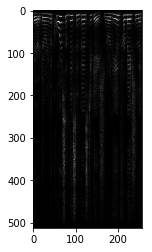

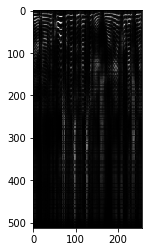

EPOCH 91


epoch 91 total 0.19737532719810194
EPOCH 92


epoch 92 total 0.19633293081714062
EPOCH 93


epoch 93 total 0.19530993292008206
EPOCH 94


epoch 94 total 0.19430896938128064
EPOCH 95


epoch 95 total 0.19332948681511522
SAVED EPOCH 96, LOSS 0.10027864302939443, BEST LOSS 0.10017112849363641


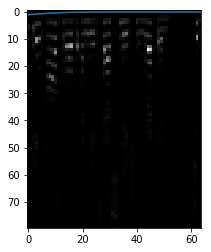

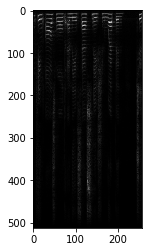

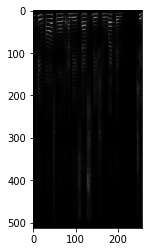

EPOCH 96


In [ ]:
startEpoch = len(lossHist)
train = 1
for epoch in range(startEpoch,startEpoch+51*train):
    print("EPOCH",epoch)
    epochLoss = []
    for step,(_,batchS,batchY) in tqdm.tqdm_notebook(enumerate(ssrnLoader)):
        batchS = batchS.to(dev)
        batchY = batchY.to(dev)
        bS = ch.autograd.Variable(batchS)
        bY = ch.autograd.Variable(batchY)
        Yhat = ssrn(bS)
        loss = MelFun(Yhat,bY)
        epochLoss.append(loss.data.item())
        ssrnOpt.zero_grad()
        loss.backward()
        ssrnOpt.step()
#         if step > 1: break
    lossHist.append(np.mean(epochLoss))
    bestLoss = min(bestLoss,lossHist[-1])
    print('epoch',epoch,'total',lossHist[-1])
    if epoch % 5 == 0:
        state = {
            'epoch': epoch + 1,
            'archparams': {'sep': params.sep, 'alpha': params.alpha},
            'modelState': ssrn.state_dict(),
            'lossHist': lossHist,
            'bestLoss': bestLoss,
            'optimizerState': ssrnOpt.state_dict() 
        }
        saveChkpt(state,model='ssrn')
        plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(bY[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(Yhat[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        if len(lossHist) > 10: plt.plot(lossHist)

In [ ]:
L,S,Y = datasets.LJSpeechDataset(ttmel=1).__getitem__(1)
L,S,Y = L.unsqueeze(0),S.unsqueeze(0),Y.unsqueeze(0)
L.shape,S.shape,Y.shape

In [ ]:
print(ch.cuda.is_available())
print(dev)
dev = 'cpu'
print(dev)
text2Mel = text2Mel.eval().to(dev)
# audioDec = audioDec.eval().to(dev)
ssrn = ssrn.eval().to(dev)

In [ ]:
# # text = "Bears. Beets. Battlestar Galactica".lower()
# text = "four score and seven years ago".lower()
# # text = "how cow brown now".lower()
# L = ch.Tensor([params.c2i[c] for c in text])
# L = ch.cat((L,ch.zeros(180-L.shape[0])))
# L = L.type(ch.LongTensor).to(dev).unsqueeze(0)

In [ ]:
# initial audio enc
# S = ch.zeros((80,217)).to(dev).unsqueeze(0)
s0 = ch.zeros((80,1)).to(dev).unsqueeze(0)
Shat = s0

In [49]:
with ch.no_grad():
    for t in tqdm.tqdm_notebook(range(100)):
        Snext,A = text2Mel(L,Shat[:,:,-100:])
#         S[:,:,t+1 ] = Shat[:,:,t]
        Shat = ch.cat((s0,Snext),dim=2)
#         S = ch.cat((S,Shat[:,:,-1:]),dim=2)

In [50]:
Yhat = ssrn(Shat)

In [51]:
def toAudio(Y):
    T = Y ** (params.eta / params.gamma) * 50
    T = T.cpu().detach().numpy().astype(np.float64)
    T = T[0].T
    T[T<0] = 0

    lwsProc = lws.lws(params.nFFT,params.hopL,mode='speech',fftsize=params.nFFT)
    T = lwsProc.run_lws(T)
    T = lwsProc.istft(T)
    return T

In [54]:
ipd.Audio(toAudio(Y),rate=22050)

In [52]:
ipd.Audio(toAudio(Yhat),rate=22050)

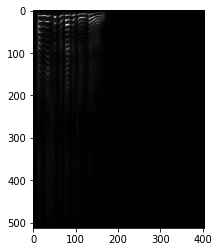

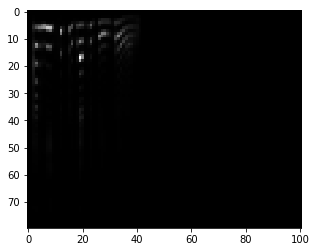

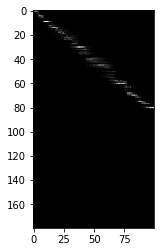

In [55]:
plt.imshow(Yhat[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(Shat[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(A[0].cpu().detach().numpy(),cmap='gray')
plt.show()

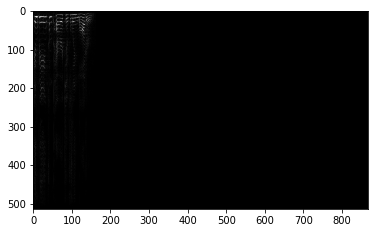

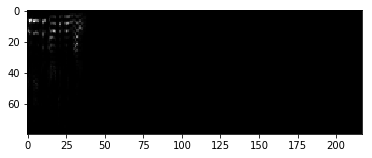

In [56]:
plt.imshow(Y[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(S[0].cpu().detach().numpy(),cmap='gray')
plt.show()